In [ ]:
!nvidia-smi

Fri Dec 18 06:56:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='14bldChJibzO4zdJ3-HC-Fhja9Ln2sa-l', dest_path='./merged_data_road_v3.zip', unzip=True)
gdd.download_file_from_google_drive(file_id='1KyPiolpOxGvKLo8CBwVxF0pDgGGpxR4S', dest_path='./merged_data_lane.zip', unzip=True)

gdd.download_file_from_google_drive(file_id='1NQoyfpAZR8iftCR57x-K0FCJrtoD2sbu', dest_path='./mobilenet_unet.pth', unzip=False)

Unzipping...Done.


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2

class UNet(nn.Module):

    def __init__(self, n_classes, backbone_pretrained=False):
        super(UNet, self).__init__()

        def conv_transpose(in_channels, out_channels, kernel_size, stride, padding, activation_fn=nn.ReLU):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                activation_fn()
            )
        
        def decode_block(in_channels, out_channels):
            return nn.Sequential(
                conv_transpose(2 * in_channels, in_channels, 3, 1, 1),
                conv_transpose(in_channels, out_channels, 3, 1, 1),
                conv_transpose(out_channels, out_channels, 2, 2, 0)
            )


        self.encoder = mobilenet_v2(backbone_pretrained).features

        for decoder_index in range(2):

            decoder = [
                conv_transpose(1280, 320, 3, 1, 1)
            ]

            channel_list = [320, 192, 64, 24, 16, 4]

            for i in range(len(channel_list) - 1):
                in_channels = channel_list[i]
                out_channels = channel_list[i+1]
                decoder.append(decode_block(in_channels, out_channels))

            decoder.append(
                nn.Sequential(
                    conv_transpose(channel_list[-1], n_classes, 3, 1, 1, nn.Sigmoid)
                )
            )

            decoder = nn.Sequential(*decoder)

            if decoder_index == 0:
                self.decoder_0 = decoder
            else:
                self.decoder_1 = decoder

    
    def forward(self, x):

        self.concat_features = []

        for index, block in enumerate(self.encoder):
            x = block(x)
            if index in [1, 3, 5, 6, 12, 13, 17]:
                self.concat_features.append(x)

        decoders = [self.decoder_0, self.decoder_1]

        z = x

        for index, decoder in enumerate(decoders):
            x = z
            concat_features = self.concat_features.copy()

            x = decoder[0](x)

            for i in range(1, len(decoder)-1):

                if i in [2, 3]:
                    x = torch.cat([x, concat_features[-1], concat_features[-2]], 1)
                    concat_features.pop()
                    concat_features.pop()
                else:
                    x = torch.cat([x, concat_features[-1]], 1)
                    concat_features.pop()
                x = decoder[i](x)
            
            x = decoder[-1](x)

            if index == 0:
                x_0 = x
            else:
                x_1 = x

        return x_0, x_1

In [ ]:
import os

import torch
from torch.utils.data import Dataset
import torchvision.transforms as tr

from PIL import Image

class DiRa(Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root

        self.split = split
        self.transform = transform

        # self.img_folder = os.path.join(self.root, self.split, 'images')
        self.img_folder = os.path.join(self.root, 'img_data')

        # self.gt_folder = os.path.join(self.root, self.split, 'ground_truths')
        self.gt_folder = os.path.join(self.root, 'gt_data')

        self.images = os.listdir(self.img_folder)
        self.images.sort()
        self.ground_truths = os.listdir(self.gt_folder)
        self.ground_truths.sort()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_file = os.path.join(self.img_folder, self.images[index])
        img = Image.open(img_file).convert('RGB')

        gt_file = os.path.join(self.gt_folder, self.ground_truths[index])
        gt = Image.open(gt_file).convert('RGB')

        if self.transform != None:
            img = self.transform(img)
            gt = self.transform(gt)

        img = tr.ToTensor()(img)
        gt = tr.ToTensor()(gt)
        gt = gt[2, :, :].unsqueeze(0)

        return img, gt

In [ ]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(DEVICE)

cuda


In [ ]:
try:
  model = torch.load('mobilenet_unet.pth')
except:
  model = UNet(1, True).to(DEVICE)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
dataloader_lane = DataLoader(
        DiRa('/content/merged_data_lane'),
        batch_size=1,
        shuffle=True,
        num_workers=1
    )


In [ ]:
dataloader_road = DataLoader(
        DiRa('/content/merged_data_road_v3'),
        batch_size=16,
        shuffle=True,
        num_workers=1
    )

In [ ]:
criterion = nn.BCELoss()

In [ ]:
optimizer_lane = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
from tqdm.notebook import tqdm

model.train()

for epoch in range(100):
    epoch_loss = 0
    epoch_step = 0
    print('Epoch: {}'.format(epoch + 1))
    for i, (img, gt) in enumerate(tqdm(dataloader_lane)):
    # for i, (img, gt) in enumerate(dataloader_lane):

        optimizer_lane.zero_grad()

        img = img.to(DEVICE)
        gt = gt.to(DEVICE)

        epoch_step += 1

        pred_0, _ = model(img)

        loss = criterion(pred_0, gt)
        loss.backward()
        optimizer_lane.step()

        epoch_loss += loss.item()

    print('Loss: {}'.format(epoch_loss / epoch_step))

Epoch: 1



Loss: 0.02213475853221211
Epoch: 2



Loss: 0.015471625092348694
Epoch: 3



Loss: 0.014249521675396018
Epoch: 4



Loss: 0.013680369336059135
Epoch: 5



Loss: 0.013206486427513636
Epoch: 6



Loss: 0.012863207948847419
Epoch: 7



Loss: 0.012593018035363175
Epoch: 8



Loss: 0.012306884599322106
Epoch: 9



Loss: 0.012157268386944073
Epoch: 10



Loss: 0.012179173175657613
Epoch: 11


KeyboardInterrupt: ignored

In [ ]:
optimizer_road = optim.Adam(model.decoder_1.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
from tqdm.notebook import tqdm

model.train()

for epoch in range(100):
    epoch_loss = 0
    epoch_step = 0
    print('Epoch: {}'.format(epoch + 1))
    for i, (img, gt) in enumerate(tqdm(dataloader_road)):
    # for i, (img, gt) in enumerate(dataloader_road):

        optimizer_road.zero_grad()

        img = img.to(DEVICE)
        gt = gt.to(DEVICE)

        epoch_step += 1

        _, pred_1 = model(img)

        loss = criterion(pred_1, gt)
        loss.backward()
        optimizer_road.step()

        epoch_loss += loss.item()

    print('Loss: {}'.format(epoch_loss / epoch_step))

Epoch: 1



Loss: 0.08253093844915858
Epoch: 2



Loss: 0.07758931104293085
Epoch: 3



Loss: 0.08049445626145774
Epoch: 4



Loss: 0.07791831825741034
Epoch: 5



Loss: 0.07860207824044144
Epoch: 6



Loss: 0.07919292300632952
Epoch: 7



Loss: 0.07667115346026519
Epoch: 8



Loss: 0.0811088452414598
Epoch: 9



Loss: 0.08053940591697463
Epoch: 10



Loss: 0.07973455838521812
Epoch: 11



Loss: 0.08428371353496494
Epoch: 12



Loss: 0.08059228349998286
Epoch: 13



Loss: 0.07647945280397625
Epoch: 14



Loss: 0.07824143617885349
Epoch: 15



Loss: 0.08105300592618837
Epoch: 16



Loss: 0.07512858879480343
Epoch: 17



Loss: 0.0784685468078886
Epoch: 18



Loss: 0.07645581589068895
Epoch: 19



Loss: 0.08174848881523306
Epoch: 20



Loss: 0.07665854101471695
Epoch: 21



Loss: 0.07955901033471151
Epoch: 22



Loss: 0.08624771580008077
Epoch: 23


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import random

dira = DiRa('/content/merged_data_road_v4')

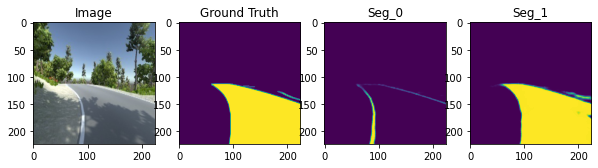

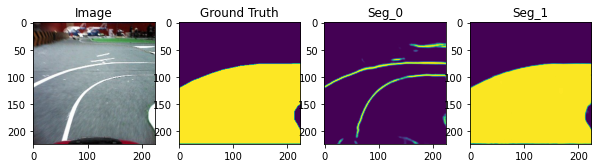

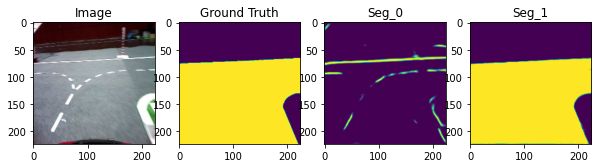

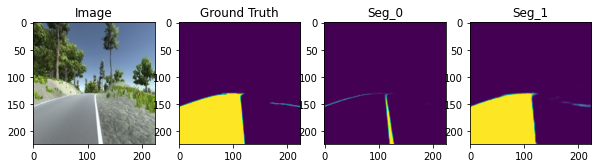

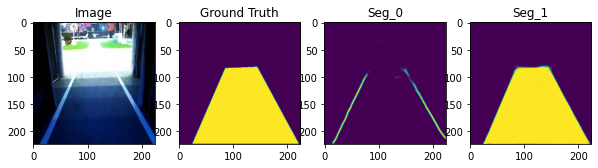

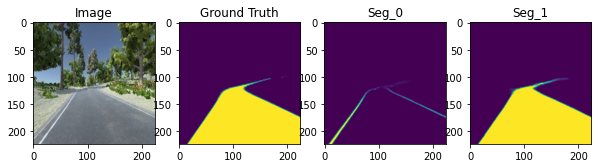

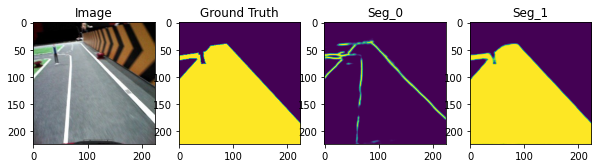

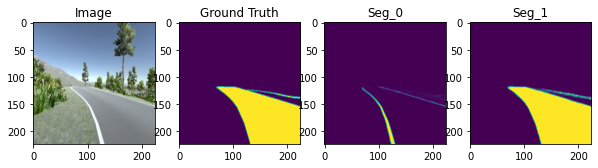

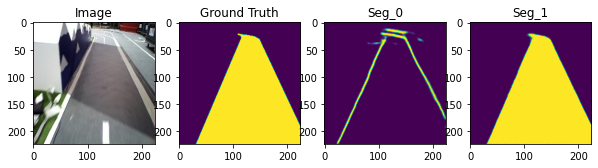

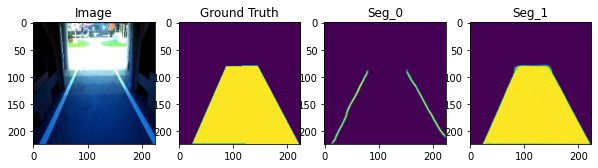

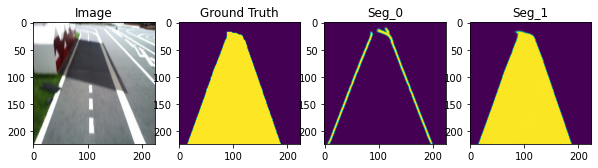

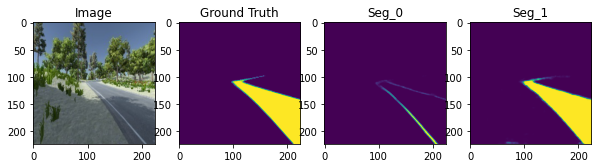

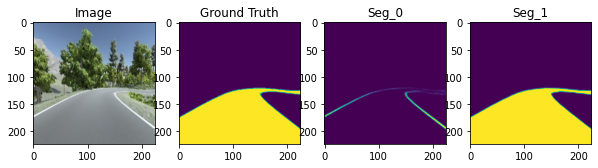

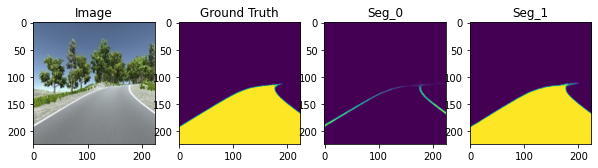

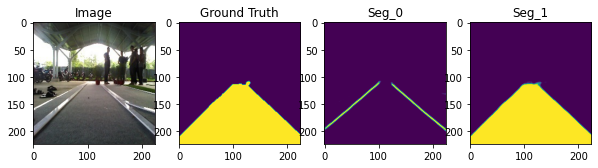

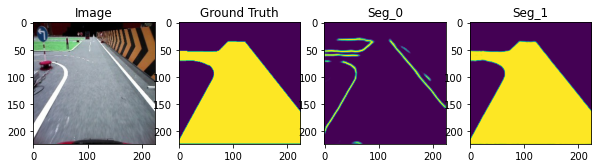

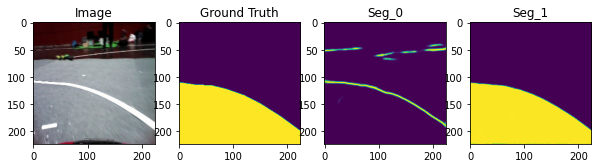

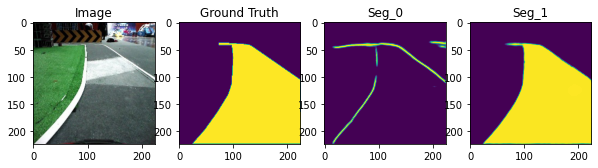

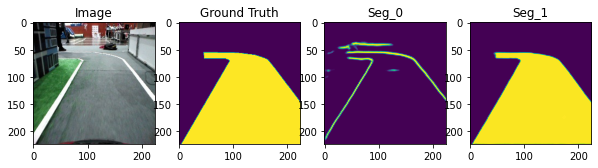

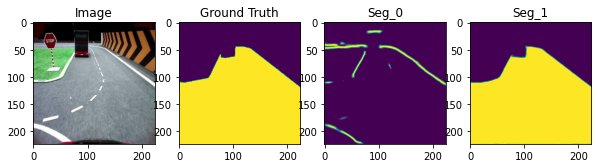

In [ ]:
for _ in range(20):

  img, gt = random.choice(dira)

  img = img.unsqueeze(0).to(DEVICE)

  pred_0, pred_1 = model(img)
  pred_0 = pred_0[0]
  pred_1 = pred_1[0]
  img = img[0]

  fig, ax = plt.subplots(1, 4, figsize=(10, 5))

  ax[0].imshow(tr.ToPILImage()(img))
  ax[0].set_title('Image')
  ax[1].imshow(tr.ToPILImage()(gt))
  ax[1].set_title('Ground Truth')
  ax[2].imshow(tr.ToPILImage()(pred_0))
  ax[2].set_title('Seg_0')
  ax[3].imshow(tr.ToPILImage()(pred_1))
  ax[3].set_title('Seg_1')


In [ ]:
input_tensor = torch.randn(1,3,224,224).to(DEVICE)

torch.onnx.export(
        model,
        input_tensor,
        'mobilenet_unet.onnx',
        export_params=True,
        opset_version=10,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output_0', 'output_1']
    )

In [ ]:
torch.save(model, 'mobilenet_unet.pth')